In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(len(sys.path), '../../data/images_classic/CIFAR-N')
from cls_names import *

In [2]:
def get_mislabeling_rate(confusion_matrix):
    """
    Calculate the mislabeling rate per class.
    """
    mislabeling_rate = dict()
    for i in range(len(confusion_matrix)):
        mislabeling_rate[i] = 1 - confusion_matrix.iloc[i][i] / confusion_matrix.iloc[i].sum()
    return mislabeling_rate

def get_confusion_matrix(path_clean_txt, path_noisy_txt, extra_info="", normalize=False):
    """
    Get the confusion matrix from the clean and noisy txt files.
    """
    clean_labels = pd.read_csv(path_clean_txt, header=None, sep=' ')
    clean_labels.columns = ['image', 'label_clean']
    noisy_labels = pd.read_csv(path_noisy_txt, header=None, sep=' ')
    noisy_labels.columns = ['image', 'label_noisy']

    print(f"{extra_info} - Found {len(clean_labels)} clean labels and {len(noisy_labels)} noisy labels.")
    #assert len(clean_labels) == len(noisy_labels)

    # merge the two dataframes
    df = pd.merge(clean_labels, noisy_labels, on="image", how="inner")
    noise_rate = 1 - np.sum(df["label_clean"] == df["label_noisy"]) / len(df)
    print(f"Noise rate {noise_rate}")
    
    # get the confusion matrix
    confusion_matrix = pd.crosstab(df['label_clean'], df['label_noisy'],normalize=normalize)

    return confusion_matrix

# functions for creating synthetic labels

In [3]:
CMAP = 'turbo'

def generate_symm_labels_from_real(
    path_clean_txt=f"cifar10/train_cifar10.txt",
    path_noisy_txt=f"cifar10/train_cifar10n_random1.txt",
    path_out=f"cifar10/train_cifar10symm_random1.txt",
    nb_classes=10,
    plot=False
):
    np.random.seed(0)
    if plot:
        cm = get_confusion_matrix(path_clean_txt, path_noisy_txt).to_numpy()
    
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(cm, cmap=CMAP)
        ax.set_title(path_noisy_txt)
        plt.show()

    train_labels = pd.read_csv(path_clean_txt, header=None, sep=' ')
    train_labels.columns = ['image', 'label_clean']
    train_noisy_labels = pd.read_csv(path_noisy_txt, header=None, sep=' ')
    train_noisy_labels.columns = ['image', 'label_noisy']
    num_mislabeled = np.sum(train_labels["label_clean"] != train_noisy_labels["label_noisy"])
    idxs = np.random.choice(range(len(train_labels)),num_mislabeled,replace=False)
    
    new_labels = train_labels["label_clean"].to_numpy()
    assert len(np.unique(new_labels)) == nb_classes
    for idx in idxs:
        cls_set = set(range(nb_classes))
        cls_set.remove(new_labels[idx])
        new_labels[idx] = np.random.choice(list(cls_set))
    train_labels["label_noisy_synth"] = new_labels
    train_labels = train_labels.set_index("image")
    print(train_labels.head())
    train_labels.to_csv(path_out, sep=" ", header=False, columns=["label_noisy_synth"])

    if plot:
        cm = get_confusion_matrix(path_clean_txt, path_out)
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(cm, cmap=CMAP)
        ax.set_title(path_out)
        plt.show()
    
        #print(cm)

def generate_symm_labels_from_percentage(
    path_clean_txt=f"fgvc-aircraft/train_fgvc-aircraft_clean.txt",
    percentage_mislabeled=0.1,
    path_out=f"fgvc-aircraft/train_fgvc-aircraft_symm0.1.txt",
    nb_classes=10,
    plot=False
):
    np.random.seed(0)
    train_labels = pd.read_csv(path_clean_txt, header=None, sep=' ')
    train_labels.columns = ['image', 'label_clean']
    
    num_mislabeled = np.round(percentage_mislabeled*len(train_labels["label_clean"])).astype(int)
    idxs = np.random.choice(range(len(train_labels)),num_mislabeled,replace=False)
    #print(idxs)
    
    new_labels = train_labels["label_clean"].to_numpy()
    assert len(np.unique(new_labels)) == nb_classes
    for idx in idxs:
        cls_set = set(range(nb_classes))
        cls_set.remove(new_labels[idx])
        new_labels[idx] = np.random.choice(list(cls_set))
    train_labels["label_noisy_synth"] = new_labels
    train_labels = train_labels.set_index("image")
    print(train_labels.head())
    train_labels.to_csv(path_out, sep=" ", header=False, columns=["label_noisy_synth"])

    if plot:
        cm = get_confusion_matrix(path_clean_txt, path_out)
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(cm, cmap=CMAP)
        ax.set_title(path_out)
        plt.show()

        #print(cm)

def multiclass_noisify_ours(y, P):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """
    np.random.seed(0)
    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    assert (P >= 0.0).all()

    m = y.shape[0]
    nb_classes = len(np.unique(y))
    print(f"{nb_classes} classes")
    #print m
    new_y = y.copy()

    for cls in range(nb_classes):
        cls_idx = np.where(y == cls)[0]
        num_total = np.sum(P[cls,:])
        assert num_total == len(cls_idx)
        num_mislabelled = num_total - P[cls,cls]
        idxs = np.random.choice(cls_idx,num_mislabelled,replace=False)
        other_classes = set(range(nb_classes))
        other_classes.remove(cls)

        total_flipped = 0
        for other_cls in other_classes:
            num_to_flip = np.sum(P[cls,other_cls])
            idxs_to_flip = idxs[total_flipped:total_flipped+num_to_flip]
            new_y[idxs_to_flip] = other_cls
            total_flipped += num_to_flip
        assert total_flipped == num_mislabelled

    return new_y

def generate_asymm_labels_from_real(
    path_clean_txt=f"cifar10/train_cifar10.txt",
    path_noisy_txt=f"cifar10/train_cifar10n_random1.txt",
    path_out=f"cifar10/train_cifar10symm_random1.txt",
    nb_classes=10,
    plot=False
):
    np.random.seed(0)
    cm = get_confusion_matrix(path_clean_txt, path_noisy_txt, normalize=False).to_numpy()

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        c = ax.imshow(cm, cmap=CMAP)
        ax.set_title(path_noisy_txt)
        plt.colorbar(c)
        plt.show()

    train_labels = pd.read_csv(path_clean_txt, header=None, sep=' ')
    train_labels.columns = ['image', 'label_clean']
    train_noisy_labels = pd.read_csv(path_noisy_txt, header=None, sep=' ')
    train_noisy_labels.columns = ['image', 'label_noisy']
    num_mislabeled = np.sum(train_labels["label_clean"] != train_noisy_labels["label_noisy"])

    new_labels = multiclass_noisify_ours(train_labels["label_clean"].to_numpy(), P=cm)
    assert len(np.unique(new_labels)) == nb_classes
    
    train_labels["label_noisy_synth"] = new_labels
    train_labels = train_labels.set_index("image")
    print(train_labels.head())
    train_labels.to_csv(path_out, sep=" ", header=False, columns=["label_noisy_synth"])

    if plot:
        cm = get_confusion_matrix(path_clean_txt, path_out)
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        c = ax.imshow(cm, cmap=CMAP)
        ax.set_title(path_out)
        plt.colorbar(c)
        plt.show()

# generating synthetic labels for each ID dataset

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.40208


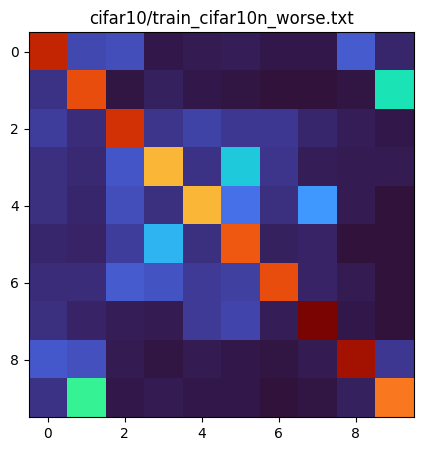

                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  3
cifar10/train/cat/1804.png            9                  9
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            5                  5
cifar10/train/cat/3961.png            6                  6
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.40208


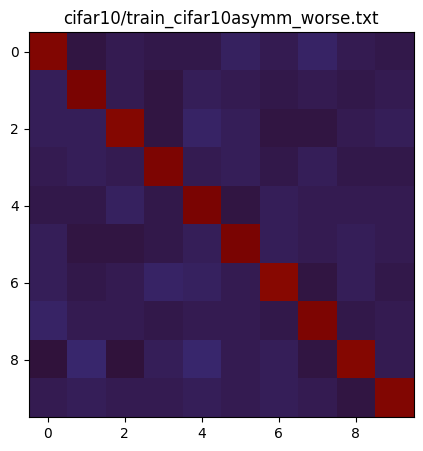

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.40208


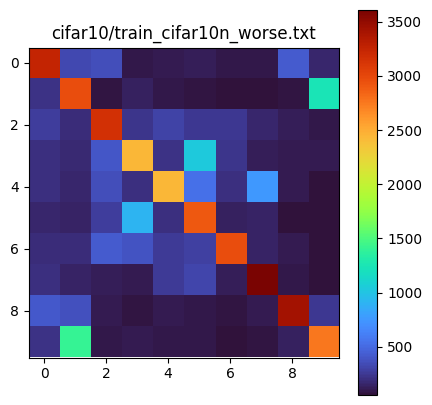

10 classes
                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  2
cifar10/train/cat/1804.png            3                  3
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            3                  3
cifar10/train/cat/3961.png            3                  3
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.40208


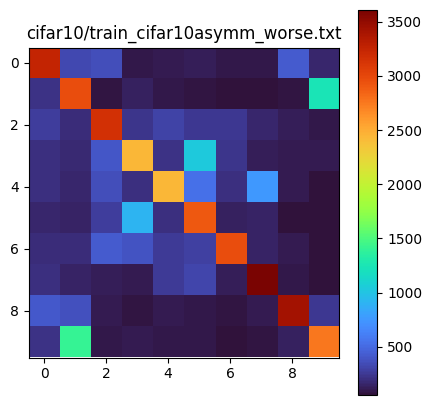

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.09009999999999996


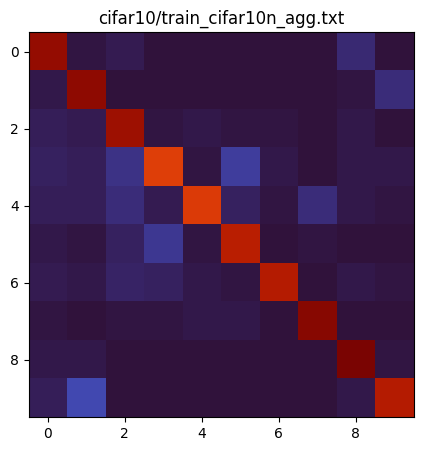

                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  3
cifar10/train/cat/1804.png            3                  3
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            3                  3
cifar10/train/cat/3961.png            3                  3
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.09009999999999996


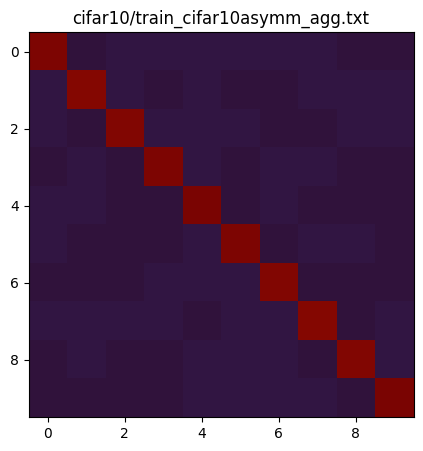

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.09009999999999996


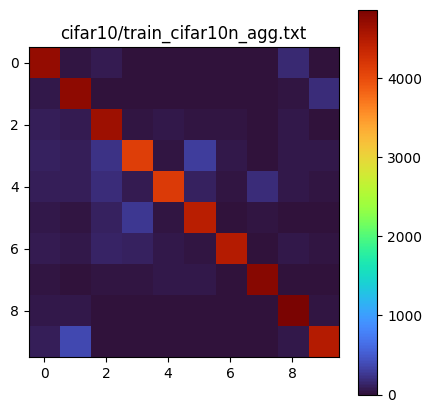

10 classes
                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  5
cifar10/train/cat/1804.png            3                  3
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            3                  3
cifar10/train/cat/3961.png            3                  3
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.09009999999999996


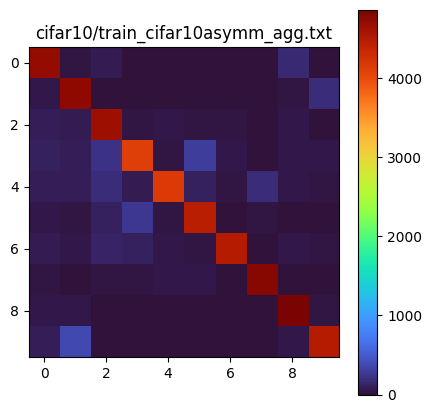

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.17234000000000005


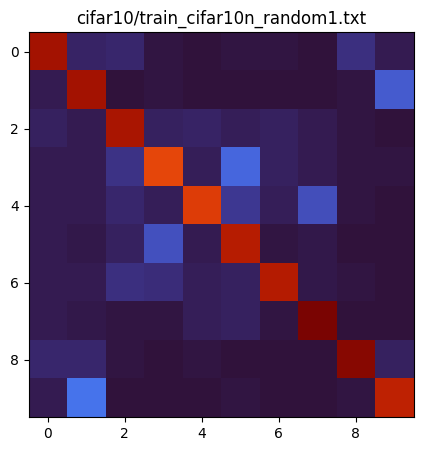

                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  3
cifar10/train/cat/1804.png            9                  9
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            5                  5
cifar10/train/cat/3961.png            3                  3
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.17234000000000005


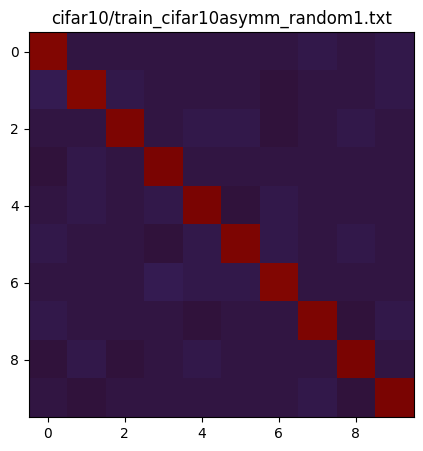

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.17234000000000005


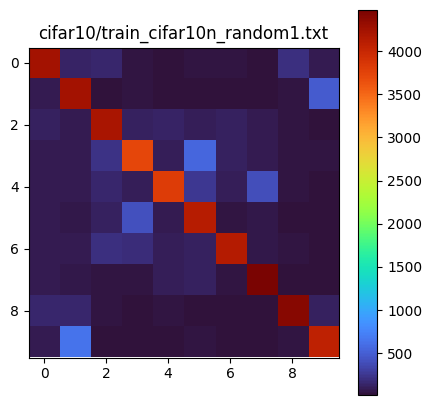

10 classes
                            label_clean  label_noisy_synth
image                                                     
cifar10/train/cat/3975.png            3                  5
cifar10/train/cat/1804.png            3                  3
cifar10/train/cat/4968.png            3                  3
cifar10/train/cat/1810.png            3                  3
cifar10/train/cat/3961.png            3                  3
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.17234000000000005


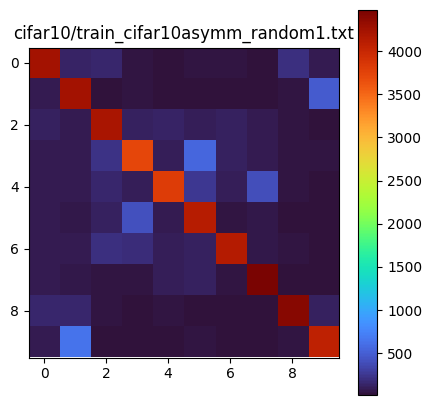

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.402


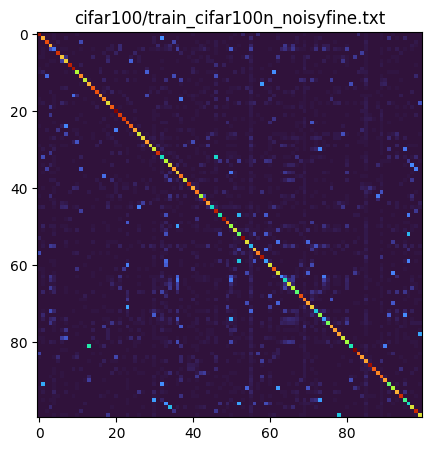

                               label_clean  label_noisy_synth
image                                                        
cifar100/train/apple/0001.png            0                  0
cifar100/train/apple/0002.png           84                 84
cifar100/train/apple/0003.png            0                  0
cifar100/train/apple/0004.png           97                 97
cifar100/train/apple/0005.png           32                 32
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.402


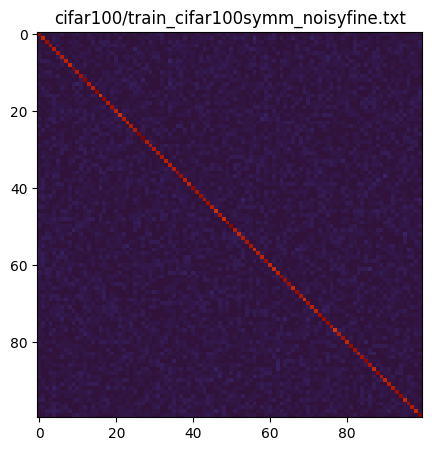

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.402


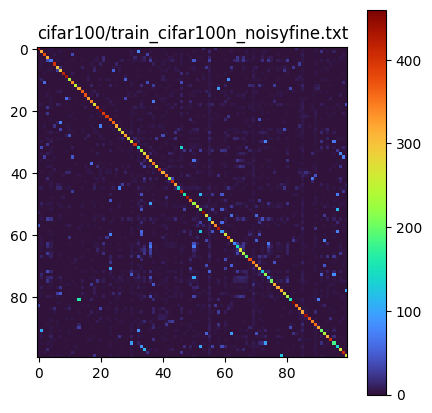

100 classes
                               label_clean  label_noisy_synth
image                                                        
cifar100/train/apple/0001.png            0                  0
cifar100/train/apple/0002.png            0                 67
cifar100/train/apple/0003.png            0                  0
cifar100/train/apple/0004.png            0                  0
cifar100/train/apple/0005.png            0                  0
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.402


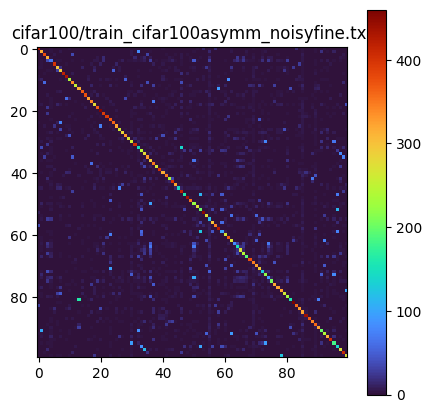

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.26404000000000005


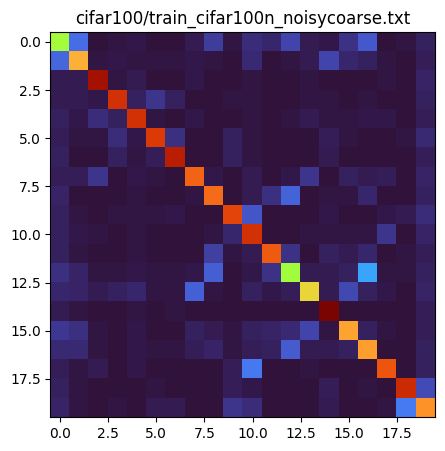

                               label_clean  label_noisy_synth
image                                                        
cifar100/train/apple/0001.png            4                  4
cifar100/train/apple/0002.png            2                  2
cifar100/train/apple/0003.png            4                  4
cifar100/train/apple/0004.png            9                  9
cifar100/train/apple/0005.png            4                  4
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.26404000000000005


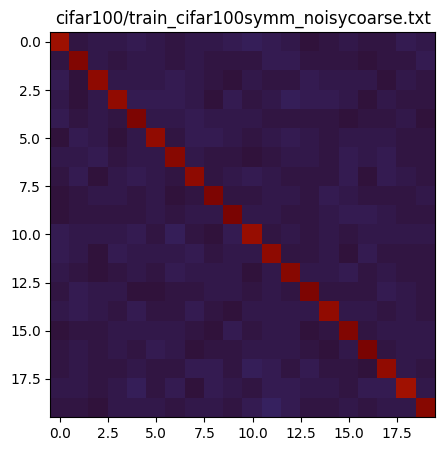

 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.26404000000000005


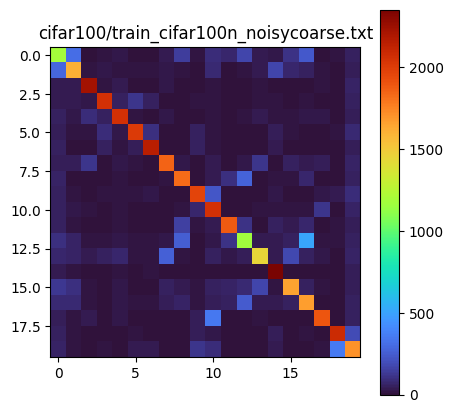

20 classes
                               label_clean  label_noisy_synth
image                                                        
cifar100/train/apple/0001.png            4                  4
cifar100/train/apple/0002.png            4                 13
cifar100/train/apple/0003.png            4                  4
cifar100/train/apple/0004.png            4                  4
cifar100/train/apple/0005.png            4                  4
 - Found 50000 clean labels and 50000 noisy labels.
Noise rate 0.26404000000000005


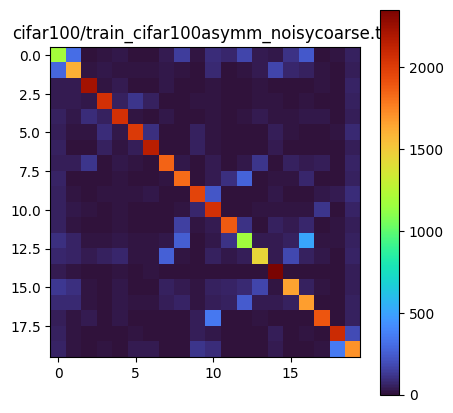

 - Found 24637 clean labels and 24637 noisy labels.
Noise rate 0.38263587287413237


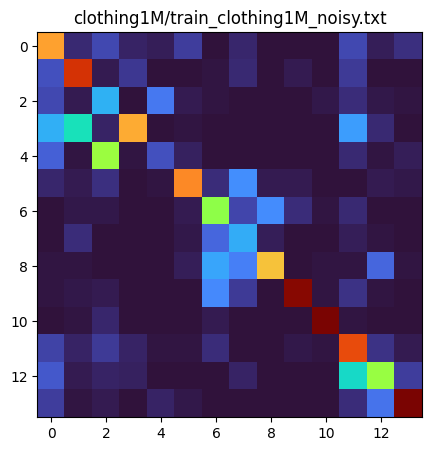

                                                  label_clean  \
image                                                           
clothing1M/images/0/00/1801019306,1542533000.jpg           13   
clothing1M/images/0/00/1850927850,668152000.jpg            12   
clothing1M/images/0/00/2026196786,3947897000.jpg            0   
clothing1M/images/0/00/2271882818,3909842000.jpg            7   
clothing1M/images/0/00/2327570466,3027662000.jpg            7   

                                                  label_noisy_synth  
image                                                                
clothing1M/images/0/00/1801019306,1542533000.jpg                 13  
clothing1M/images/0/00/1850927850,668152000.jpg                  12  
clothing1M/images/0/00/2026196786,3947897000.jpg                  0  
clothing1M/images/0/00/2271882818,3909842000.jpg                  7  
clothing1M/images/0/00/2327570466,3027662000.jpg                  7  
 - Found 24637 clean labels and 24637 noisy labels.
No

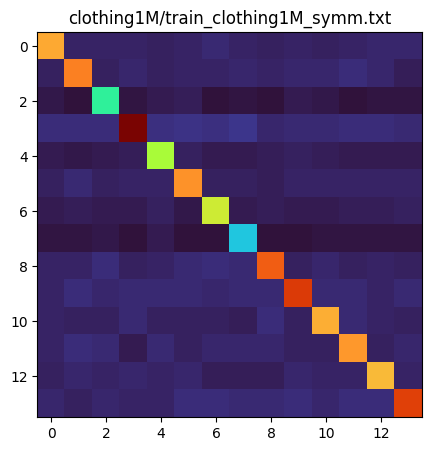

 - Found 24637 clean labels and 24637 noisy labels.
Noise rate 0.38263587287413237


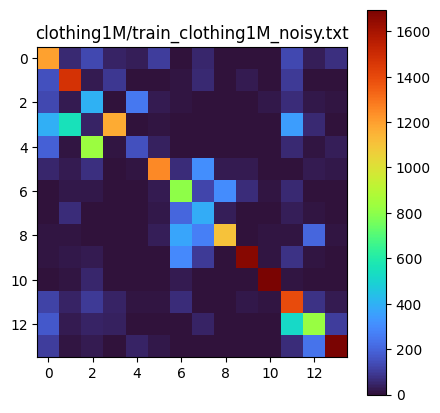

14 classes
                                                  label_clean  \
image                                                           
clothing1M/images/0/00/1801019306,1542533000.jpg           13   
clothing1M/images/0/00/1850927850,668152000.jpg             3   
clothing1M/images/0/00/2026196786,3947897000.jpg            0   
clothing1M/images/0/00/2271882818,3909842000.jpg            7   
clothing1M/images/0/00/2327570466,3027662000.jpg            3   

                                                  label_noisy_synth  
image                                                                
clothing1M/images/0/00/1801019306,1542533000.jpg                 13  
clothing1M/images/0/00/1850927850,668152000.jpg                  11  
clothing1M/images/0/00/2026196786,3947897000.jpg                  0  
clothing1M/images/0/00/2271882818,3909842000.jpg                  7  
clothing1M/images/0/00/2327570466,3027662000.jpg                  3  
 - Found 24637 clean labels and 24637 noisy

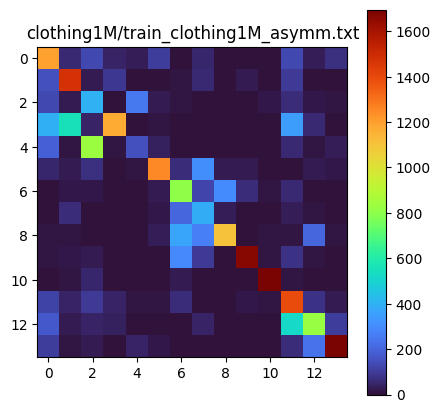

                                             label_clean  label_noisy_synth
image                                                                      
fgvc-aircraft-2013b/data/images/0056978.jpg            0                  0
fgvc-aircraft-2013b/data/images/0698580.jpg            0                  0
fgvc-aircraft-2013b/data/images/0450014.jpg            0                  0
fgvc-aircraft-2013b/data/images/1042824.jpg            0                  0
fgvc-aircraft-2013b/data/images/0894380.jpg            0                  0
 - Found 2682 clean labels and 2682 noisy labels.
Noise rate 0.09992542878448918


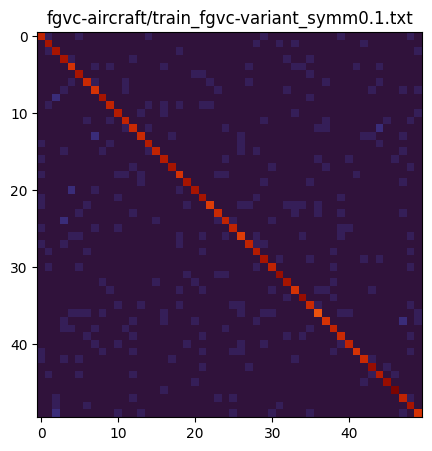

                                                    label_clean  \
image                                                             
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   

                                                    label_noisy_synth  
image                                                                  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
 - Found 2400 clean labels

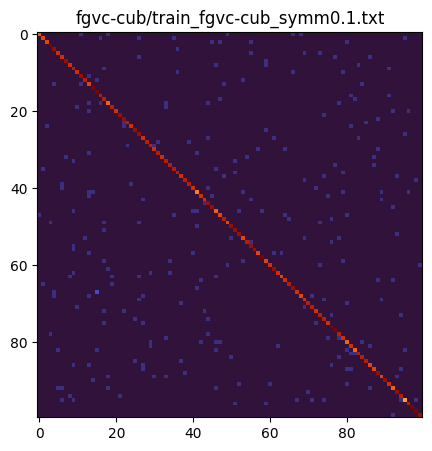

                                             label_clean  label_noisy_synth
image                                                                      
fgvc-aircraft-2013b/data/images/0056978.jpg            0                  0
fgvc-aircraft-2013b/data/images/0698580.jpg            0                  0
fgvc-aircraft-2013b/data/images/0450014.jpg            0                  0
fgvc-aircraft-2013b/data/images/1042824.jpg            0                  0
fgvc-aircraft-2013b/data/images/0894380.jpg           31                 31
 - Found 2682 clean labels and 2682 noisy labels.
Noise rate 0.19985085756897836


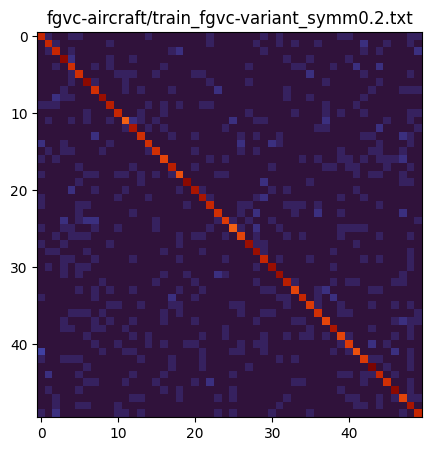

                                                    label_clean  \
image                                                             
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...           58   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   
CUB_200_2011/CUB_200_2011/images/001.Black_foot...            0   

                                                    label_noisy_synth  
image                                                                  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                 58  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
CUB_200_2011/CUB_200_2011/images/001.Black_foot...                  0  
 - Found 2400 clean labels

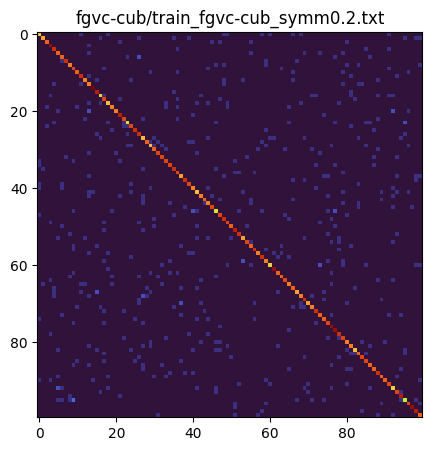

In [4]:
PLOT_CONFUSION_MATRIX = True

# CIFAR10
for subset in ["worse","agg","random1"]:
    generate_symm_labels_from_real(
       path_clean_txt=f"cifar10/train_cifar10.txt",
       path_noisy_txt=f"cifar10/train_cifar10n_{subset}.txt",
       path_out=f"cifar10/train_cifar10asymm_{subset}.txt",
       nb_classes=10,
       plot=PLOT_CONFUSION_MATRIX
    )

    generate_asymm_labels_from_real(
           path_clean_txt=f"cifar10/train_cifar10.txt",
           path_noisy_txt=f"cifar10/train_cifar10n_{subset}.txt",
           path_out=f"cifar10/train_cifar10asymm_{subset}.txt",
           nb_classes=10,
           plot=PLOT_CONFUSION_MATRIX
       )

# CIFAR100
for subset in ["noisyfine","noisycoarse"]:
    generate_symm_labels_from_real(
        path_clean_txt=f"cifar100/train_cifar100.txt"  if subset == "noisyfine" else f"cifar100/train_cifar100n_cleancoarse.txt",
        path_noisy_txt=f"cifar100/train_cifar100n_{subset}.txt",
        path_out=f"cifar100/train_cifar100symm_{subset}.txt",
        nb_classes=100 if subset == "noisyfine" else 20,
        plot=PLOT_CONFUSION_MATRIX
    )

    generate_asymm_labels_from_real(
        path_clean_txt=f"cifar100/train_cifar100.txt"  if subset == "noisyfine" else f"cifar100/train_cifar100n_cleancoarse.txt",
        path_noisy_txt=f"cifar100/train_cifar100n_{subset}.txt",
        path_out=f"cifar100/train_cifar100asymm_{subset}.txt",
        nb_classes=100 if subset == "noisyfine" else 20,
        plot=PLOT_CONFUSION_MATRIX
    )

# Clothing1M
generate_symm_labels_from_real(
    path_clean_txt=f"clothing1M/train_clothing1M_clean.txt",
    path_noisy_txt=f"clothing1M/train_clothing1M_noisy.txt",
    path_out=f"clothing1M/train_clothing1M_symm.txt",
    nb_classes=14,
    plot=PLOT_CONFUSION_MATRIX
)

generate_asymm_labels_from_real(
    path_clean_txt=f"clothing1M/train_clothing1M_clean.txt",
    path_noisy_txt=f"clothing1M/train_clothing1M_noisy.txt",
    path_out=f"clothing1M/train_clothing1M_asymm.txt",
    nb_classes=14,
    plot=PLOT_CONFUSION_MATRIX
)

# FGVC datasets
for perc in [0.1,0.2]:
    generate_symm_labels_from_percentage(
        path_clean_txt=f"fgvc-aircraft/train_fgvc-variant_clean.txt",
        percentage_mislabeled=perc,
        path_out=f"fgvc-aircraft/train_fgvc-variant_symm{perc}.txt",
        nb_classes=50,
        plot=PLOT_CONFUSION_MATRIX
    )

    generate_symm_labels_from_percentage(
        path_clean_txt=f"fgvc-cub/train_fgvc-cub_clean.txt",
        percentage_mislabeled=perc,
        path_out=f"fgvc-cub/train_fgvc-cub_symm{perc}.txt",
        nb_classes=100,
        plot=PLOT_CONFUSION_MATRIX
    )